In [43]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# **Chia train test validate theo tỉ lệ 8:1:1**

In [44]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BTC.csv')
df1=df.reset_index()['Close']

In [45]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [46]:
# 4. Chia train test validate theo tỉ lệ 8:1:1
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [47]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [48]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [49]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [50]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [51]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
23/23 [==============================] - 11s 265ms/step - loss: 0.0276 - val_loss: 0.0057
Epoch 2/100
23/23 [==============================] - 3s 143ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 3/100
23/23 [==============================] - 3s 144ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/100
23/23 [==============================] - 5s 201ms/step - loss: 0.0023 - val_loss: 9.8426e-04
Epoch 5/100
23/23 [==============================] - 3s 146ms/step - loss: 0.0022 - val_loss: 9.0765e-04
Epoch 6/100
23/23 [==============================] - 3s 144ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 7/100
23/23 [==============================] - 3s 144ms/step - loss: 0.0021 - val_loss: 8.9713e-04
Epoch 8/100
23/23 [==============================] - 5s 206ms/step - loss: 0.0019 - val_loss: 8.6396e-04
Epoch 9/100
23/23 [==============================] - 3s 144ms/step - loss: 0.0018 - val_loss: 8.2412e-04
Epoch 10/100
23/23 [==============================] - 3s 146ms/step - 

In [52]:
# 10. Dự báo dữ liệu test, val
train_predict = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

3/3 [==============================] - 0s 31ms/step


In [53]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [54]:
# 12. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, ytest)
test_rmse = np.sqrt(np.mean((y_pred_test - ytest)**2))
test_mape = mean_absolute_percentage_error(y_pred_test, ytest)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_pred_val, yval)
val_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 597.7329271488766
Testing RMSE: 811.861814561863
Testing MAPE: 0.02142648674310185
---------------------------
Validation MAE: 2556.8962679027773
Validation RMSE: 3088.041296082788
Validation MAPE: 0.04164032170715356


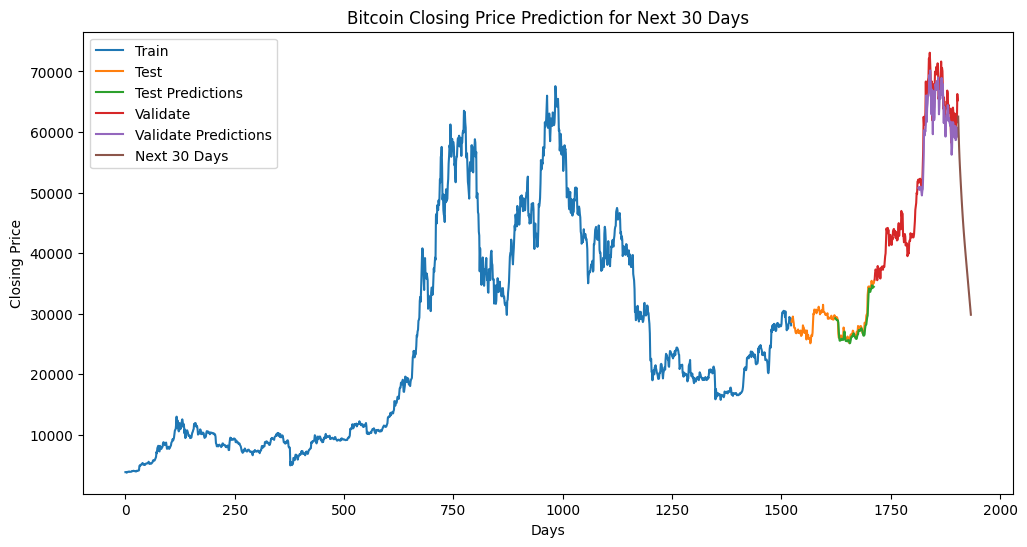

Predicted closing prices for the next 30 days:
[62542.71  59918.777 57580.88  55711.355 54161.402 52750.008 51387.266
 50055.97  48769.145 47542.348 46383.477 45292.207 44262.848 43287.035
 42355.605 41459.562 40590.582 39741.227 38905.113 38076.92  37252.54
 36428.96  35604.31  34777.742 33949.348 33120.07  32291.518 31465.893
 30645.729 29833.879]


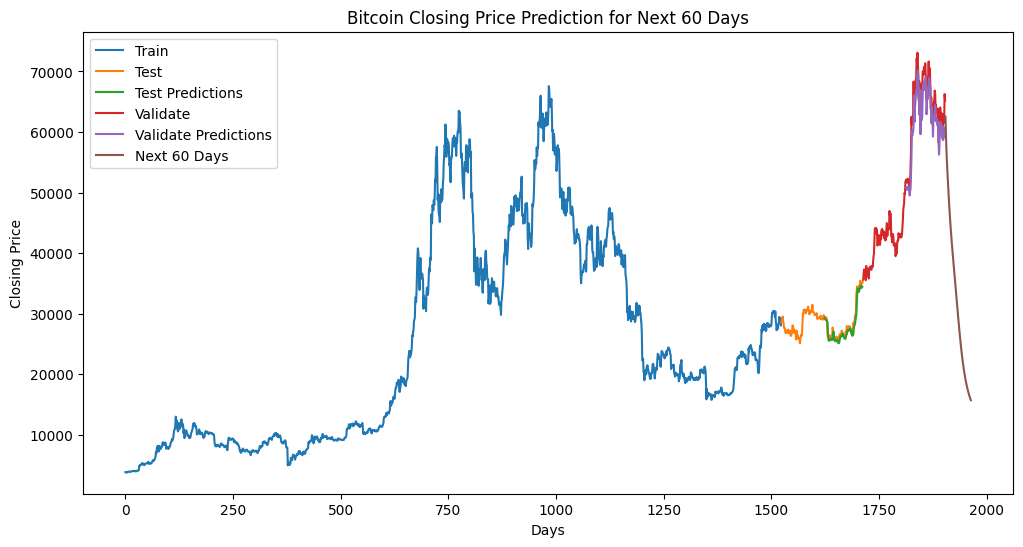

Predicted closing prices for the next 60 days:
[62542.71  59918.777 57580.88  55711.355 54161.402 52750.008 51387.266
 50055.97  48769.145 47542.348 46383.477 45292.207 44262.848 43287.035
 42355.605 41459.562 40590.582 39741.227 38905.113 38076.92  37252.54
 36428.96  35604.31  34777.742 33949.348 33120.07  32291.518 31465.893
 30645.729 29833.879 29033.281 28246.887 27477.5   26727.762 26000.01
 25296.258 24618.154 23966.959 23343.553 22748.453 22181.85  21643.598
 21133.27  20650.252 20193.68  19762.55  19355.75  18972.086 18610.297
 18269.102 17947.209 17643.36  17356.318 17084.898 16827.973 16584.465
 16353.371 16133.774 15924.809 15725.68 ]


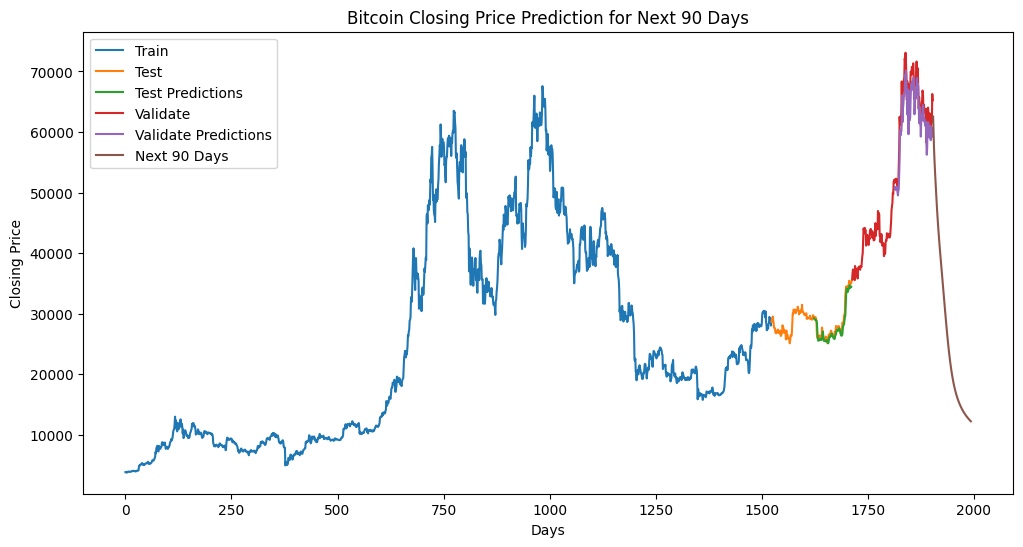

Predicted closing prices for the next 90 days:
[62542.71  59918.777 57580.88  55711.355 54161.402 52750.008 51387.266
 50055.97  48769.145 47542.348 46383.477 45292.207 44262.848 43287.035
 42355.605 41459.562 40590.582 39741.227 38905.113 38076.92  37252.54
 36428.96  35604.31  34777.742 33949.348 33120.07  32291.518 31465.893
 30645.729 29833.879 29033.281 28246.887 27477.5   26727.762 26000.01
 25296.258 24618.154 23966.959 23343.553 22748.453 22181.85  21643.598
 21133.27  20650.252 20193.68  19762.55  19355.75  18972.086 18610.297
 18269.102 17947.209 17643.36  17356.318 17084.898 16827.973 16584.465
 16353.371 16133.774 15924.809 15725.68  15535.67  15354.111 15180.408
 15014.006 14854.421 14701.199 14553.933 14412.251 14275.836 14144.371
 14017.59  13895.233 13777.073 13662.89  13552.485 13445.674 13342.28
 13242.136 13145.087 13050.987 12959.692 12871.067 12784.991 12701.339
 12619.996 12540.85  12463.795 12388.739 12315.584 12244.239]


In [55]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), scaler.inverse_transform(val_data), label='Validate')
    plt.plot(range(len(train_data) + len(test_data) + time_step, len(train_data) + len(test_data) + time_step + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 7:2:1**

In [56]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BTC.csv')
df1=df.reset_index()['Close']

In [57]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [58]:
# 4. Chia train test validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [59]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [60]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [61]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [62]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [63]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 11s 279ms/step - loss: 0.0289 - val_loss: 0.0011
Epoch 2/100
20/20 [==============================] - 5s 225ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 3/100
20/20 [==============================] - 4s 176ms/step - loss: 0.0030 - val_loss: 7.1432e-04
Epoch 4/100
20/20 [==============================] - 3s 152ms/step - loss: 0.0026 - val_loss: 6.7061e-04
Epoch 5/100
20/20 [==============================] - 5s 235ms/step - loss: 0.0025 - val_loss: 9.1794e-04
Epoch 6/100
20/20 [==============================] - 4s 174ms/step - loss: 0.0024 - val_loss: 6.1164e-04
Epoch 7/100
20/20 [==============================] - 3s 152ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/100
20/20 [==============================] - 3s 150ms/step - loss: 0.0022 - val_loss: 6.5653e-04
Epoch 9/100
20/20 [==============================] - 4s 219ms/step - loss: 0.0018 - val_loss: 5.1198e-04
Epoch 10/100
20/20 [==============================] - 3s 151ms/ste

In [64]:
# 10. Dự báo dữ liệu test, val
train_predict = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

3/3 [==============================] - 0s 71ms/step


In [65]:
# 11. Chuẩn hóa dữ liệu
train_predict = scaler.inverse_transform(train_predict)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [66]:
# 12. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, ytest)
test_rmse = np.sqrt(np.mean((y_pred_test - ytest)**2))
test_mape = mean_absolute_percentage_error(y_pred_test, ytest)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_pred_val, yval)
val_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 620.8715065927418
Testing RMSE: 790.0838525167231
Testing MAPE: 0.022566464040440975
---------------------------
Validation MAE: 1645.9153068681314
Validation RMSE: 2175.2427640746446
Validation MAPE: 0.025736144249550574


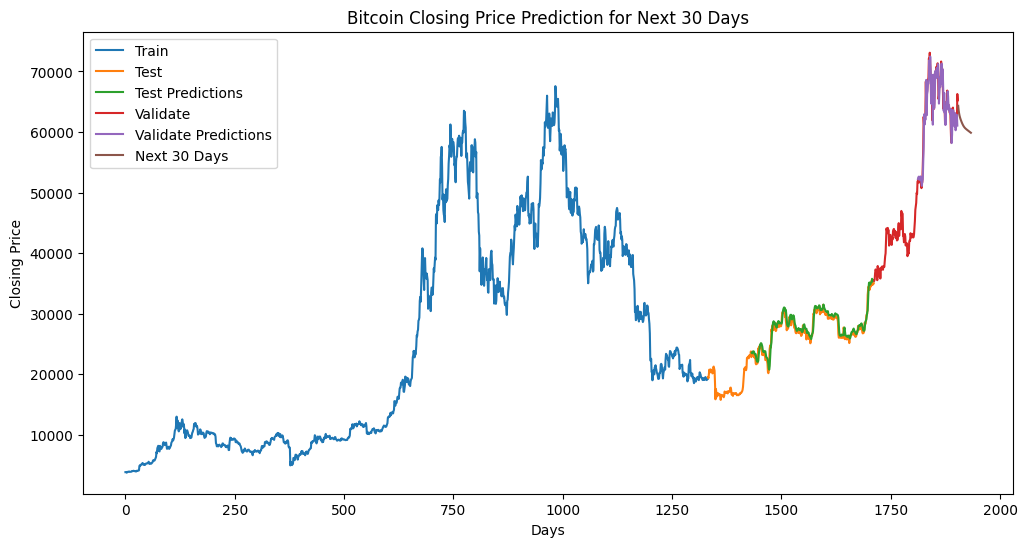

Predicted closing prices for the next 30 days:
[64319.473 63605.766 63100.79  62727.777 62439.527 62202.125 61992.727
 61798.73  61615.402 61442.71  61282.617 61137.11  61007.22  60892.777
 60792.574 60704.695 60626.9   60556.85  60492.473 60431.957 60373.895
 60317.227 60261.25  60205.46  60149.625 60093.645 60037.684 59982.016
 59926.902 59872.71 ]


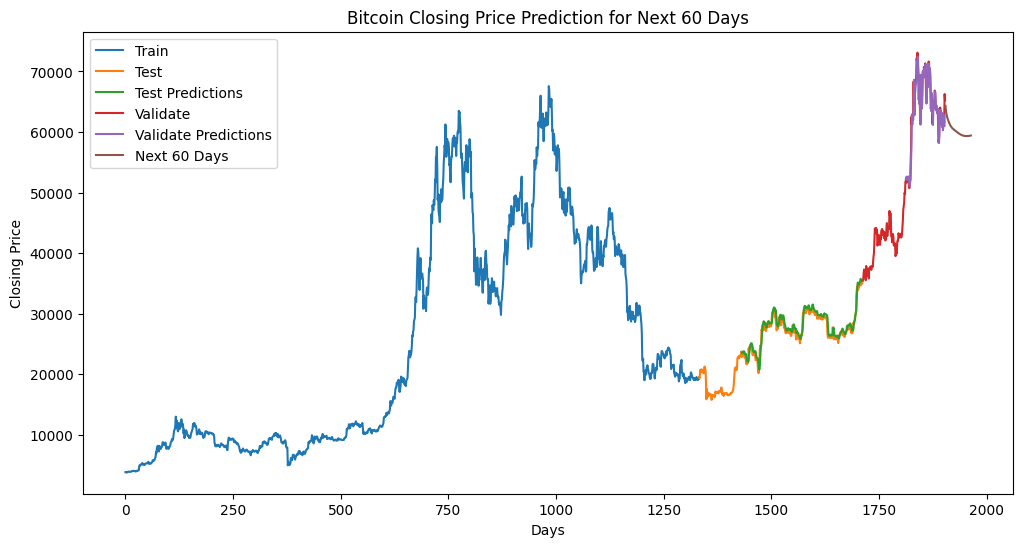

Predicted closing prices for the next 60 days:
[64319.473 63605.766 63100.79  62727.777 62439.527 62202.125 61992.727
 61798.73  61615.402 61442.71  61282.617 61137.11  61007.22  60892.777
 60792.574 60704.695 60626.9   60556.85  60492.473 60431.957 60373.895
 60317.227 60261.25  60205.46  60149.625 60093.645 60037.684 59982.016
 59926.902 59872.71  59819.848 59768.676 59719.56  59672.83  59628.79
 59587.652 59549.586 59514.688 59482.96  59454.38  59428.953 59406.64
 59387.285 59370.89  59357.312 59346.406 59338.047 59332.18  59328.7
 59327.49  59328.406 59331.36  59336.207 59342.832 59351.184 59361.145
 59372.57  59385.383 59399.55  59415.03 ]


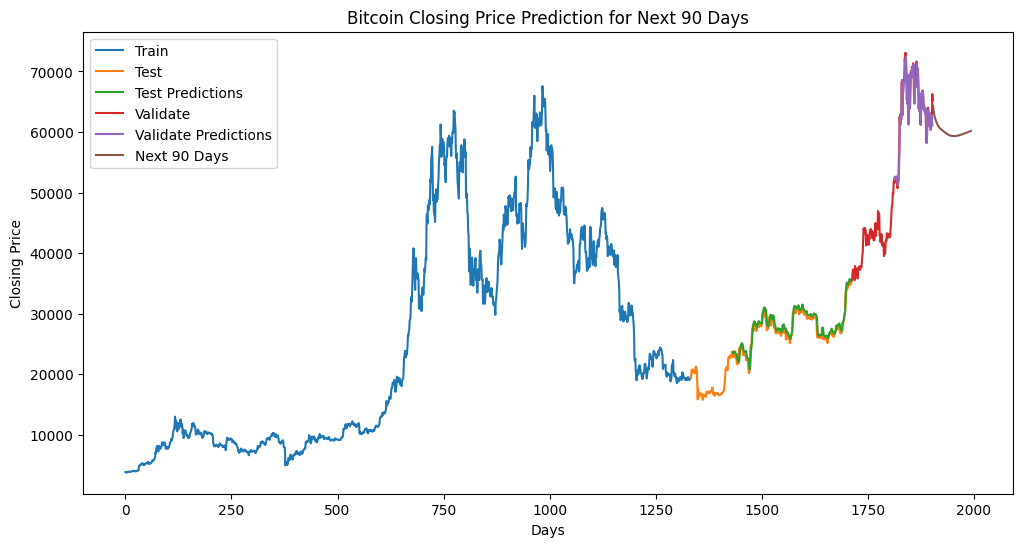

Predicted closing prices for the next 90 days:
[64319.473 63605.766 63100.79  62727.777 62439.527 62202.125 61992.727
 61798.73  61615.402 61442.71  61282.617 61137.11  61007.22  60892.777
 60792.574 60704.695 60626.9   60556.85  60492.473 60431.957 60373.895
 60317.227 60261.25  60205.46  60149.625 60093.645 60037.684 59982.016
 59926.902 59872.71  59819.848 59768.676 59719.56  59672.83  59628.79
 59587.652 59549.586 59514.688 59482.96  59454.38  59428.953 59406.64
 59387.285 59370.89  59357.312 59346.406 59338.047 59332.18  59328.7
 59327.49  59328.406 59331.36  59336.207 59342.832 59351.184 59361.145
 59372.57  59385.383 59399.55  59415.03  59431.76  59449.72  59468.805
 59488.965 59510.117 59532.195 59555.1   59578.723 59603.04  59627.96
 59653.426 59679.355 59705.734 59732.523 59759.67  59787.094 59814.777
 59842.67  59870.66  59898.707 59926.746 59954.72  59982.59  60010.324
 60037.82  60065.02  60091.914 60118.51  60144.805 60170.777]


In [67]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), scaler.inverse_transform(val_data), label='Validate')
    plt.plot(range(len(train_data) + len(test_data) + time_step, len(train_data) + len(test_data) + time_step + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 6:2:2**

In [68]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BTC.csv')
df1=df.reset_index()['Close']

In [69]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [70]:
# 4. Chia train test validate theo tỉ lệ 6:2:2
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [71]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [72]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [73]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [74]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [75]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 11s 245ms/step - loss: 0.0473 - val_loss: 0.0014
Epoch 2/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 3/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0034 - val_loss: 8.6747e-04
Epoch 4/100
17/17 [==============================] - 4s 221ms/step - loss: 0.0028 - val_loss: 6.2661e-04
Epoch 5/100
17/17 [==============================] - 3s 166ms/step - loss: 0.0027 - val_loss: 7.2644e-04
Epoch 6/100
17/17 [==============================] - 4s 261ms/step - loss: 0.0026 - val_loss: 6.3162e-04
Epoch 7/100
17/17 [==============================] - 3s 155ms/step - loss: 0.0024 - val_loss: 8.5472e-04
Epoch 8/100
17/17 [==============================] - 4s 230ms/step - loss: 0.0023 - val_loss: 7.3326e-04
Epoch 9/100
17/17 [==============================] - 3s 160ms/step - loss: 0.0022 - val_loss: 5.7371e-04
Epoch 10/100
17/17 [==============================] - 3s 154ms

In [76]:
# 10. Dự báo dữ liệu test, val
train_predict = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

9/9 [==============================] - 1s 77ms/step


In [77]:
# 11. Chuẩn hóa dữ liệu
train_predict = scaler.inverse_transform(train_predict)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [78]:
# 12. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, ytest)
test_rmse = np.sqrt(np.mean((y_pred_test - ytest)**2))
test_mape = mean_absolute_percentage_error(y_pred_test, ytest)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_pred_val, yval)
val_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 558.6204009565414
Testing RMSE: 835.399306678621
Testing MAPE: 0.025987683629471965
---------------------------
Validation MAE: 1615.1791040814055
Validation RMSE: 2304.981498767227
Validation MAPE: 0.03306421583775862


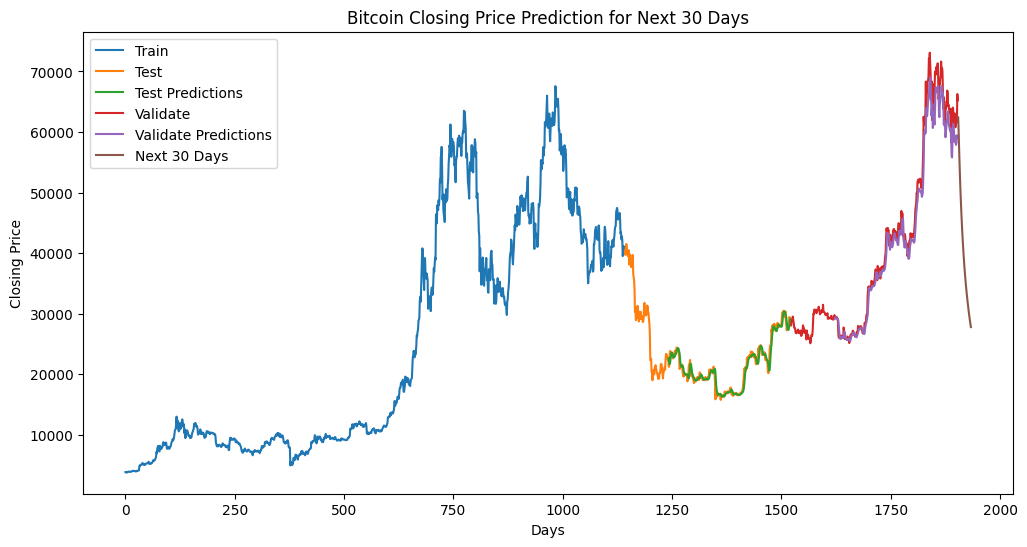

Predicted closing prices for the next 30 days:
[62415.29  60166.484 57506.75  55012.895 52740.01  50673.37  48784.637
 47047.25  45441.457 43953.348 42572.785 41291.566 40102.094 38996.812
 37967.957 37007.76  36108.598 35263.285 34465.383 33709.23  32990.168
 32304.396 31649.074 31021.95  30421.617 29847.121 29297.965 28774.021
 28275.031 27801.145]


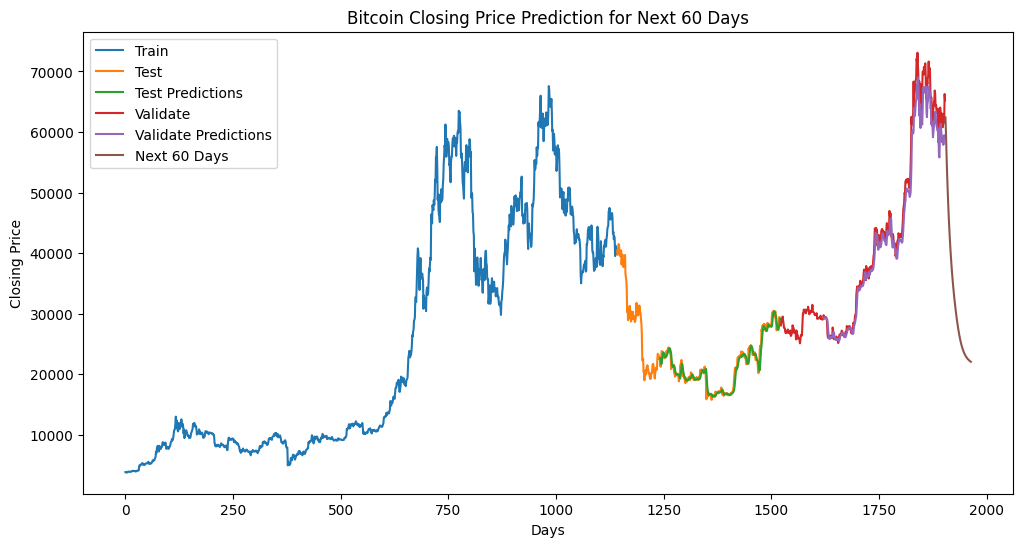

Predicted closing prices for the next 60 days:
[62415.29  60166.484 57506.75  55012.895 52740.01  50673.37  48784.637
 47047.25  45441.457 43953.348 42572.785 41291.566 40102.094 38996.812
 37967.957 37007.76  36108.598 35263.285 34465.383 33709.23  32990.168
 32304.396 31649.074 31021.95  30421.617 29847.121 29297.965 28774.021
 28275.031 27801.145 27352.314 26928.479 26529.438 26154.88  25804.37
 25477.232 25172.732 24889.941 24627.861 24385.404 24161.525 23955.016
 23764.668 23589.453 23428.14  23279.654 23142.97  23017.11  22901.14
 22794.178 22695.414 22604.12  22519.602 22441.246 22368.502 22300.84
 22237.793 22178.97  22124.008 22072.566]


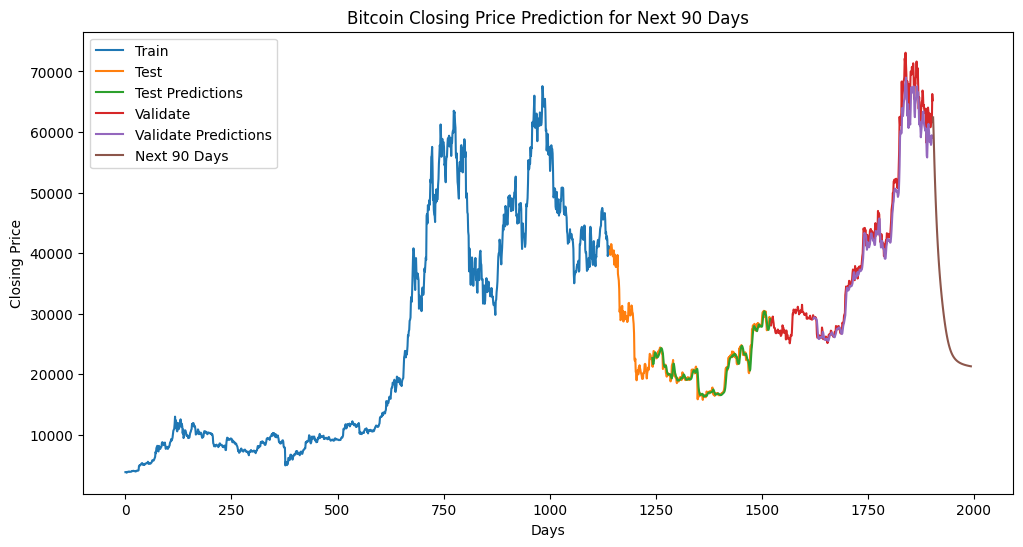

Predicted closing prices for the next 90 days:
[62415.29  60166.484 57506.75  55012.895 52740.01  50673.37  48784.637
 47047.25  45441.457 43953.348 42572.785 41291.566 40102.094 38996.812
 37967.957 37007.76  36108.598 35263.285 34465.383 33709.23  32990.168
 32304.396 31649.074 31021.95  30421.617 29847.121 29297.965 28774.021
 28275.031 27801.145 27352.314 26928.479 26529.438 26154.88  25804.37
 25477.232 25172.732 24889.941 24627.861 24385.404 24161.525 23955.016
 23764.668 23589.453 23428.14  23279.654 23142.97  23017.11  22901.14
 22794.178 22695.414 22604.12  22519.602 22441.246 22368.502 22300.84
 22237.793 22178.97  22124.008 22072.566 22024.357 21979.11  21936.594
 21896.578 21858.875 21823.305 21789.7   21757.906 21727.799 21699.244
 21672.139 21646.36  21621.826 21598.434 21576.111 21554.771 21534.336
 21514.754 21495.94  21477.852 21460.42  21443.6   21427.342 21411.607
 21396.35  21381.52  21367.104 21353.059 21339.36  21325.975]


In [79]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), scaler.inverse_transform(val_data), label='Validate')
    plt.plot(range(len(train_data) + len(test_data) + time_step, len(train_data) + len(test_data) + time_step + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())